### Data Analysis Notebook

In this notebook, we explore the demographic aspects of the data.

####1. Mounting Data

We first started with mounting to the correct Azure Data Lake Storage:

- **/mnt/output**: mounting alias for model output and plot images
- **/mnt/dim**: excel dataset about the patients
- **/mnt/datasets**: transformed dataset

In [0]:
#mount dimension container 
try:
  dbutils.fs.mount(
    source = "wasbs://dimension@chestxraystorage1.blob.core.windows.net", #change images-sample to images to connect to all images
    mount_point = "/mnt/dim",
    extra_configs = {"fs.azure.account.key.chestxraystorage1.blob.core.windows.net":"VtYP71BSCTyhUtCeGkMSmRRnAvTPVC3v4RxDy9sQEBOdtWCWF2BWp4lsEm0iSkLI1/pmfKO3GrjWVfMCjTD1MA=="})
except:
  print('Already mounted')
  
  
#mount datasets container 
try:
  dbutils.fs.mount(
    source = "wasbs://datasets@chestxraystorage1.blob.core.windows.net", #change images-sample to images to connect to all images
    mount_point = "/mnt/datasets",
    extra_configs = {"fs.azure.account.key.chestxraystorage1.blob.core.windows.net":"VtYP71BSCTyhUtCeGkMSmRRnAvTPVC3v4RxDy9sQEBOdtWCWF2BWp4lsEm0iSkLI1/pmfKO3GrjWVfMCjTD1MA=="})
except:
  print('Already mounted')
  
  
#mount output container 
try:
  dbutils.fs.mount(
    source = "wasbs://output@chestxray2.blob.core.windows.net", #change images-sample to images to connect to all images
    mount_point = "/mnt/output",
    extra_configs = {"fs.azure.account.key.chestxray2.blob.core.windows.net":"JKSEUUF32ek7eIoQIWRiC4jFzZbdBDKGhcJoowGY0/3G3RRYFv/nt21MoG+jBqPloNxEP8GHSwuysFDlrZr7Og=="})
except:
  print('Already mounted')

Already mounted
Already mounted
Already mounted

In [0]:
#Add needed packages
from pyspark.sql.functions import *
import torchvision.models as models
import torch
import torchvision
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
#from torchsummary import summary
import torch.optim as optim
import numpy as np
import pandas as pd
#import cv2
from pyspark import SparkContext
import random

import matplotlib.pyplot as plt; plt.rcdefaults()
 
import matplotlib.pyplot as plt

####2. Data Exploration

In this section, we applied aggregation and data exploration techniques to have better understanding of the data

In [0]:
df_response = spark.read.csv("/mnt/dim/Data_Entry_2017_v2020.csv",header=True)

In [0]:
df_response = df_response.select(col('Image Index').alias('name'),
                        col('Finding Labels').alias('label'),
                        col('Follow-up #').alias('followUp'),
                        col('Patient ID').alias('pId'),
                        col('Patient Age').alias('Age'),
                        col('Patient Gender').alias('Gender'),
                        col('View Position').alias('Position'),
                        col('OriginalImage[Width').alias('W'),
                        col('Height]').alias('H'),
                        col('OriginalImagePixelSpacing[x').alias('x'),
                        col('y]').alias('y'))
df_response.show(truncate=False)

+----------------+----------------------+--------+---+---+------+--------+----+----+-------------------+-------------------+
name |label |followUp|pId|Age|Gender|Position|W |H |x |y |
+----------------+----------------------+--------+---+---+------+--------+----+----+-------------------+-------------------+
00000001_000.png|Cardiomegaly |0 |1 |57 |M |PA |2682|2749|0.14300000000000002|0.14300000000000002|
00000001_001.png|Cardiomegaly|Emphysema|1 |1 |58 |M |PA |2894|2729|0.14300000000000002|0.14300000000000002|
00000001_002.png|Cardiomegaly|Effusion |2 |1 |58 |M |PA |2500|2048|0.168 |0.168 |
00000002_000.png|No Finding |0 |2 |80 |M |PA |2500|2048|0.171 |0.171 |
00000003_001.png|Hernia |0 |3 |74 |F |PA |2500|2048|0.168 |0.168 |
00000003_002.png|Hernia |1 |3 |75 |F |PA |2048|2500|0.168 |0.168 |
00000003_003.png|Hernia|Infiltration |2 |3 |76 |F |PA |2698|2991|0.14300000000000002|0.14300000000000002|
00000003_004.png|Hernia |3 |3 |77 |F |PA |2500|2048|0.168 |0.168 |
00000003_005.png|Hernia |4 |3 |78 |F |PA |2686|2991|0.14300000000000002|0.14300000000000002|
00000003_006.png|Hernia |5 |3 |79 |F |PA |2992|2991|0.14300000000000002|0.14300000000000002|
00000003_007.png|Hernia |6 |3 |80 |F |PA |2582|2905|0.14300000000000002|0.14300000000000002|
00000003_000.png|Hernia |7 |3 |81 |F |PA |2582|2991|0.14300000000000002|0.14300000000000002|
00000004_000.png|Mass|Nodule |0 |4 |82 |M |AP |2500|2048|0.168 |0.168 |
00000005_000.png|No Finding |0 |5 |69 |F |PA |2048|2500|0.168 |0.168 |
00000005_001.png|No Finding |1 |5 |69 |F |AP |2500|2048|0.168 |0.168 |
00000005_002.png|No Finding |2 |5 |69 |F |AP |2500|2048|0.168 |0.168 |
00000005_003.png|No Finding |3 |5 |69 |F |PA |2992|2991|0.14300000000000002|0.14300000000000002|
00000005_004.png|No Finding |4 |5 |70 |F |PA |2986|2991|0.14300000000000002|0.14300000000000002|
00000005_005.png|No Finding |5 |5 |70 |F |PA |2514|2991|0.14300000000000002|0.14300000000000002|
00000005_006.png|Infiltration |6 |5 |70 |F |PA |2992|2991|0.14300000000000002|0.14300000000000002|
+----------------+----------------------+--------+---+---+------+--------+----+----+-------------------+-------------------+
only showing top 20 rows

In [0]:
df_response.groupBy('label').agg({"name": "count" }).collect()

Out[37]: [Row(label='Fibrosis|Pneumonia', count(name)=5),
 Row(label='Hernia|Pneumothorax', count(name)=2),
 Row(label='Atelectasis|Effusion|Mass|Pleural_Thickening', count(name)=5),
 Row(label='Atelectasis|Infiltration|Pleural_Thickening|Pneumonia', count(name)=2),
 Row(label='Effusion|Emphysema|Fibrosis|Mass|Nodule', count(name)=1),
 Row(label='Cardiomegaly|Infiltration', count(name)=200),
 Row(label='Atelectasis|Edema', count(name)=48),
 Row(label='Cardiomegaly|Effusion|Infiltration|Pleural_Thickening', count(name)=5),
 Row(label='Atelectasis|Infiltration|Mass', count(name)=67),
 Row(label='Mass|Pleural_Thickening|Pneumothorax', count(name)=15),
 Row(label='Atelectasis|Cardiomegaly|Effusion|Infiltration|Nodule', count(name)=6),
 Row(label='Atelectasis|Cardiomegaly|Effusion', count(name)=68),
 Row(label='Infiltration|Pneumonia|Pneumothorax', count(name)=5),
 Row(label='Fibrosis|Pneumothorax', count(name)=23),
 Row(label='Fibrosis|Mass|Pneumothorax', count(name)=2),
 Row(label='Cardiomegaly|Fibrosis|Nodule', count(name)=2),
 Row(label='Atelectasis|Consolidation|Effusion|Emphysema|Pneumothorax', count(name)=1),
 Row(label='Atelectasis|Consolidation|Effusion|Pneumothorax', count(name)=7),
 Row(label='Consolidation|Effusion|Infiltration|Pneumonia', count(name)=5),
 Row(label='Edema|Effusion|Nodule', count(name)=10),
 Row(label='Consolidation|Effusion|Infiltration', count(name)=134),
 Row(label='Edema|Infiltration|Pneumonia', count(name)=137),
 Row(label='Atelectasis|Effusion|Fibrosis|Infiltration|Mass', count(name)=2),
 Row(label='Mass', count(name)=2139),
 Row(label='Nodule|Pleural_Thickening|Pneumothorax', count(name)=6),
 Row(label='Atelectasis|Mass|Pneumonia', count(name)=2),
 Row(label='Atelectasis|Cardiomegaly|Consolidation|Edema|Effusion|Pleural_Thickening', count(name)=2),
 Row(label='Fibrosis|Infiltration', count(name)=185),
 Row(label='Emphysema|Pleural_Thickening', count(name)=46),
 Row(label='Effusion|Nodule|Pleural_Thickening|Pneumothorax', count(name)=3),
 Row(label='Consolidation|Hernia|Mass', count(name)=1),
 Row(label='Infiltration|Nodule', count(name)=829),
 Row(label='Atelectasis|Mass|Pleural_Thickening', count(name)=7),
 Row(label='Mass|Pneumothorax', count(name)=178),
 Row(label='Atelectasis|Consolidation|Effusion', count(name)=200),
 Row(label='Atelectasis|Fibrosis|Mass', count(name)=3),
 Row(label='Atelectasis|Effusion|Infiltration', count(name)=737),
 Row(label='Emphysema|Infiltration|Mass', count(name)=16),
 Row(label='Emphysema|Hernia|Pleural_Thickening', count(name)=1),
 Row(label='Effusion|Pneumothorax|Pneumonia', count(name)=1),
 Row(label='Edema|Infiltration|Mass', count(name)=23),
 Row(label='Cardiomegaly|Infiltration|Pleural_Thickening', count(name)=6),
 Row(label='Fibrosis|Hernia|Mass', count(name)=1),
 Row(label='Edema|Emphysema|Mass|Pneumothorax', count(name)=1),
 Row(label='Atelectasis|Cardiomegaly|Emphysema|Mass|Pneumothorax', count(name)=1),
 Row(label='Atelectasis|Consolidation|Effusion|Infiltration|Nodule', count(name)=2),
 Row(label='Effusion|Nodule|Pneumothorax', count(name)=15),
 Row(label='Atelectasis|Infiltration|Mass|Nodule', count(name)=8),
 Row(label='Consolidation|Effusion|Emphysema|Mass', count(name)=1),
 Row(label='Consolidation|Infiltration', count(name)=441),
 Row(label='Effusion|Fibrosis|Nodule|Pleural_Thickening', count(name)=3),
 Row(label='Atelectasis|Emphysema|Pleural_Thickening', count(name)=4),
 Row(label='Edema|Effusion|Infiltration', count(name)=127),
 Row(label='Fibrosis|Nodule', count(name)=66),
 Row(label='Atelectasis|Emphysema', count(name)=117),
 Row(label='Hernia|Mass', count(name)=15),
 Row(label='Atelectasis|Emphysema|Mass', count(name)=15),
 Row(label='Consolidation|Emphysema', count(name)=20),
 Row(label='Atelectasis|Consolidation|Infiltration|Pneumonia', count(name)=4),
 Row(label='Atelectasis|Consolidation|Fibrosis|Nodule', count(name)=2),
 Row(label='Cardiomegaly|Infiltration|Nodule', count(name)=7),
 Row(label='Atelectasis|Consolidation|Mass|Pneumonia', 

In [0]:
print('The following shows patients ordered by number of images :' )
df_response.groupBy('pId').agg({"name": "count" }).orderBy('count(name)', ascending = 0).collect()

The following shows patients ordered by number of images :
Out[38]: [Row(pId='10007', count(name)=184),
 Row(pId='13670', count(name)=173),
 Row(pId='15530', count(name)=158),
 Row(pId='12834', count(name)=157),
 Row(pId='13993', count(name)=143),
 Row(pId='1836', count(name)=137),
 Row(pId='19124', count(name)=130),
 Row(pId='20213', count(name)=119),
 Row(pId='17138', count(name)=117),
 Row(pId='11237', count(name)=116),
 Row(pId='13111', count(name)=116),
 Row(pId='21201', count(name)=114),
 Row(pId='17236', count(name)=111),
 Row(pId='20326', count(name)=109),
 Row(pId='6271', count(name)=108),
 Row(pId='19176', count(name)=108),
 Row(pId='14022', count(name)=108),
 Row(pId='4808', count(name)=102),
 Row(pId='16587', count(name)=99),
 Row(pId='18253', count(name)=91),
 Row(pId='22572', count(name)=90),
 Row(pId='27213', count(name)=90),
 Row(pId='4858', count(name)=89),
 Row(pId='10531', count(name)=88),
 Row(pId='3028', count(name)=87),
 Row(pId='11702', count(name)=86),
 Row(pId='4893', count(name)=86),
 Row(pId='12021', count(name)=86),
 Row(pId='25252', count(name)=84),
 Row(pId='22416', count(name)=84),
 Row(pId='7034', count(name)=83),
 Row(pId='4006', count(name)=81),
 Row(pId='13625', count(name)=81),
 Row(pId='22815', count(name)=81),
 Row(pId='12364', count(name)=80),
 Row(pId='27415', count(name)=80),
 Row(pId='11925', count(name)=79),
 Row(pId='11460', count(name)=77),
 Row(pId='26451', count(name)=77),
 Row(pId='18921', count(name)=76),
 Row(pId='27725', count(name)=76),
 Row(pId='10352', count(name)=75),
 Row(pId='30079', count(name)=74),
 Row(pId='12628', count(name)=73),
 Row(pId='19271', count(name)=73),
 Row(pId='13615', count(name)=71),
 Row(pId='20408', count(name)=71),
 Row(pId='8468', count(name)=70),
 Row(pId='19576', count(name)=70),
 Row(pId='8008', count(name)=69),
 Row(pId='3393', count(name)=69),
 Row(pId='13310', count(name)=69),
 Row(pId='17504', count(name)=69),
 Row(pId='14203', count(name)=69),
 Row(pId='18187', count(name)=69),
 Row(pId='12094', count(name)=68),
 Row(pId='3528', count(name)=68),
 Row(pId='8522', count(name)=68),
 Row(pId='18366', count(name)=68),
 Row(pId='5066', count(name)=67),
 Row(pId='583', count(name)=67),
 Row(pId='25787', count(name)=67),
 Row(pId='10828', count(name)=66),
 Row(pId='181', count(name)=66),
 Row(pId='16508', count(name)=66),
 Row(pId='26412', count(name)=66),
 Row(pId='19373', count(name)=66),
 Row(pId='28876', count(name)=66),
 Row(pId='8841', count(name)=65),
 Row(pId='15732', count(name)=65),
 Row(pId='18360', count(name)=65),
 Row(pId='11391', count(name)=64),
 Row(pId='12087', count(name)=64),
 Row(pId='18233', count(name)=64),
 Row(pId='25849', count(name)=63),
 Row(pId='20482', count(name)=63),
 Row(pId='13917', count(name)=63),
 Row(pId='7018', count(name)=62),
 Row(pId='6304', count(name)=62),
 Row(pId='4342', count(name)=62),
 Row(pId='11683', count(name)=62),
 Row(pId='13774', count(name)=62),
 Row(pId='15646', count(name)=62),
 Row(pId='17747', count(name)=62),
 Row(pId='468', count(name)=61),
 Row(pId='32', count(name)=61),
 Row(pId='16291', count(name)=61),
 Row(pId='27726', count(name)=61),
 Row(pId='18972', count(name)=61),
 Row(pId='16410', count(name)=61),
 Row(pId='15605', count(name)=61),
 Row(pId='13685', count(name)=61),
 Row(pId='11355', count(name)=60),
 Row(pId='9863', count(name)=60),
 Row(pId='13249', count(name)=60),
 Row(pId='459', count(name)=59),
 Row(pId='14125', count(name)=59),
 Row(pId='20945', count(name)=59),
 Row(pId='10294', count(name)=58),
 Row(pId='12045', count(name)=58),
 Row(pId='14663', count(name)=58),
 Row(pId='14320', count(name)=58),
 Row(pId='14253', count(name)=57),
 Row(pId='15606', count(name)=57),
 Row(pId='5722', count(name)=56),
 Row(pId='1170', count(name)=56),
 Row(pId='9845', count(name)=56),
 Row(pId='1373', count(name)=56),
 Row(pId='23068', count(name)=56),
 Row(pId='20673', count(name)=56),
 Row(pId='30323', count(name)=56),
 Row(pId='10805', count(name)=55),
 Row(pId='2437', count(name)

In [0]:
df_response.groupBy('pId').agg({"name": "count" }).orderBy('count(name)', ascending = 1).collect()

Out[39]: [Row(pId='675', count(name)=1),
 Row(pId='691', count(name)=1),
 Row(pId='829', count(name)=1),
 Row(pId='1090', count(name)=1),
 Row(pId='1436', count(name)=1),
 Row(pId='1572', count(name)=1),
 Row(pId='2069', count(name)=1),
 Row(pId='2088', count(name)=1),
 Row(pId='2136', count(name)=1),
 Row(pId='2162', count(name)=1),
 Row(pId='2294', count(name)=1),
 Row(pId='3210', count(name)=1),
 Row(pId='3414', count(name)=1),
 Row(pId='4032', count(name)=1),
 Row(pId='5325', count(name)=1),
 Row(pId='6240', count(name)=1),
 Row(pId='6613', count(name)=1),
 Row(pId='7252', count(name)=1),
 Row(pId='7273', count(name)=1),
 Row(pId='7711', count(name)=1),
 Row(pId='9009', count(name)=1),
 Row(pId='9586', count(name)=1),
 Row(pId='10096', count(name)=1),
 Row(pId='10351', count(name)=1),
 Row(pId='11078', count(name)=1),
 Row(pId='11332', count(name)=1),
 Row(pId='11563', count(name)=1),
 Row(pId='11722', count(name)=1),
 Row(pId='11888', count(name)=1),
 Row(pId='12394', count(name)=1),
 Row(pId='12529', count(name)=1),
 Row(pId='12847', count(name)=1),
 Row(pId='13442', count(name)=1),
 Row(pId='13610', count(name)=1),
 Row(pId='5645', count(name)=1),
 Row(pId='5925', count(name)=1),
 Row(pId='125', count(name)=1),
 Row(pId='451', count(name)=1),
 Row(pId='1372', count(name)=1),
 Row(pId='1669', count(name)=1),
 Row(pId='2110', count(name)=1),
 Row(pId='3015', count(name)=1),
 Row(pId='3441', count(name)=1),
 Row(pId='3858', count(name)=1),
 Row(pId='4838', count(name)=1),
 Row(pId='4894', count(name)=1),
 Row(pId='5023', count(name)=1),
 Row(pId='6558', count(name)=1),
 Row(pId='7362', count(name)=1),
 Row(pId='7743', count(name)=1),
 Row(pId='7994', count(name)=1),
 Row(pId='8306', count(name)=1),
 Row(pId='9003', count(name)=1),
 Row(pId='9032', count(name)=1),
 Row(pId='9308', count(name)=1),
 Row(pId='9569', count(name)=1),
 Row(pId='9830', count(name)=1),
 Row(pId='10309', count(name)=1),
 Row(pId='11205', count(name)=1),
 Row(pId='11236', count(name)=1),
 Row(pId='11247', count(name)=1),
 Row(pId='12637', count(name)=1),
 Row(pId='12888', count(name)=1),
 Row(pId='9975', count(name)=1),
 Row(pId='666', count(name)=1),
 Row(pId='919', count(name)=1),
 Row(pId='1241', count(name)=1),
 Row(pId='1361', count(name)=1),
 Row(pId='1746', count(name)=1),
 Row(pId='1870', count(name)=1),
 Row(pId='2530', count(name)=1),
 Row(pId='2696', count(name)=1),
 Row(pId='2700', count(name)=1),
 Row(pId='2725', count(name)=1),
 Row(pId='2917', count(name)=1),
 Row(pId='3200', count(name)=1),
 Row(pId='3836', count(name)=1),
 Row(pId='3838', count(name)=1),
 Row(pId='3949', count(name)=1),
 Row(pId='4127', count(name)=1),
 Row(pId='5044', count(name)=1),
 Row(pId='5181', count(name)=1),
 Row(pId='5757', count(name)=1),
 Row(pId='6848', count(name)=1),
 Row(pId='7248', count(name)=1),
 Row(pId='7263', count(name)=1),
 Row(pId='7378', count(name)=1),
 Row(pId='8621', count(name)=1),
 Row(pId='8832', count(name)=1),
 Row(pId='10114', count(name)=1),
 Row(pId='10250', count(name)=1),
 Row(pId='10730', count(name)=1),
 Row(pId='10784', count(name)=1),
 Row(pId='11106', count(name)=1),
 Row(pId='12104', count(name)=1),
 Row(pId='12204', count(name)=1),
 Row(pId='13041', count(name)=1),
 Row(pId='13170', count(name)=1),
 Row(pId='13395', count(name)=1),
 Row(pId='13660', count(name)=1),
 Row(pId='7', count(name)=1),
 Row(pId='51', count(name)=1),
 Row(pId='124', count(name)=1),
 Row(pId='1903', count(name)=1),
 Row(pId='1953', count(name)=1),
 Row(pId='2034', count(name)=1),
 Row(pId='2550', count(name)=1),
 Row(pId='2895', count(name)=1),
 Row(pId='2930', count(name)=1),
 Row(pId='3121', count(name)=1),
 Row(pId='3266', count(name)=1),
 Row(pId='3652', count(name)=1),
 Row(pId='4236', count(name)=1),
 Row(pId='4249', count(name)=1),
 Row(pId='4988', count(name)=1),
 Row(pId='5057', count(name)=1),
 Row(pId='5082', count(name)=1),
 Row(pId='5234', count(name)=1),
 Row(pId='5297', count(name)=1),
 Row(pId='5320', count(name)=1),
 Row(pId='5408'

In [0]:
df_response.groupBy(["pId", "gender"]).agg({"pId": "first" }).groupBy([ "gender"]).agg({"pId": "count" }).collect()

Out[40]: [Row(gender='F', count(pId)=14175), Row(gender='M', count(pId)=16630)]

In [0]:
print(df_response.agg({"Age": "max"}).collect())
print(df_response.agg({"Age": "min"}).collect())
print(df_response.agg({"Age": "avg"}).collect())

[Row(max(Age)='95')]
[Row(min(Age)='0')]
[Row(avg(Age)=46.62636460934713)]

In [0]:
df_response.describe(['name','label', 'followUp', 'pId', 'Age' , 'Gender' , 'Position' ]).show()

+-------+----------------+--------------------+------------------+------------------+-----------------+------+--------+
summary| name| label| followUp| pId| Age|Gender|Position|
+-------+----------------+--------------------+------------------+------------------+-----------------+------+--------+
 count| 112120| 112120| 112120| 112120| 112120|112120| 112120|
 mean| null| null| 8.5737513378523|14346.381742775598|46.62636460934713| null| null|
 stddev| null| null|15.406319709328265| 8403.876972049708|16.60267981756067| null| null|
 min|00000001_000.png| Atelectasis| 0| 1| 0| F| AP|
 max|00030805_000.png|Pneumothorax|Pneu...| 99| 9999| 95| M| PA|
+-------+----------------+--------------------+------------------+------------------+-----------------+------+--------+

In [0]:
df_response.summary()['summary', 'name','label', 'followUp', 'pId', 'Age' , 'Gender' , 'Position' ].show()

+-------+----------------+--------------------+------------------+------------------+-----------------+------+--------+
summary| name| label| followUp| pId| Age|Gender|Position|
+-------+----------------+--------------------+------------------+------------------+-----------------+------+--------+
 count| 112120| 112120| 112120| 112120| 112120|112120| 112120|
 mean| null| null| 8.5737513378523|14346.381742775598|46.62636460934713| null| null|
 stddev| null| null|15.406319709328265| 8403.876972049708|16.60267981756067| null| null|
 min|00000001_000.png| Atelectasis| 0| 1| 0| F| AP|
 25%| null| null| 0.0| 7310.0| 34.0| null| null|
 50%| null| null| 3.0| 13993.0| 49.0| null| null|
 75%| null| null| 10.0| 20673.0| 59.0| null| null|
 max|00030805_000.png|Pneumothorax|Pneu...| 99| 9999| 95| M| PA|
+-------+----------------+--------------------+------------------+------------------+-----------------+------+--------+

In [0]:
print( 'Number of Atelectasis cases : ' + str(df_response.filter(" upper(label) like '%ATELECTASIS%' ").count()))
print( 'Number of Consolidation cases : ' + str(df_response.filter(" upper(label) like '%CONSOLIDATION%' ").count()))
print( 'Number of Infiltration cases : ' + str(df_response.filter(" upper(label) like '%INFILTRATION%' ").count()))
 
print( 'Number of Pneumothorax cases : ' + str(df_response.filter(" upper(label) like '%PNEUMOTHORAX%' ").count()))
print( 'Number of Edema cases : ' + str(df_response.filter(" upper(label) like '%EDEMA%' ").count()))
print( 'Number of Emphysema cases : ' + str(df_response.filter(" upper(label) like '%EMPHYSEMA%' ").count()))
print( 'Number of Fibrosis cases : ' + str(df_response.filter(" upper(label) like '%FIBROSIS%' ").count()))
print( 'Number of Effusion cases : ' + str(df_response.filter(" upper(label) like '%EFFUSION%' ").count()))
print( 'Number of Pneumonia cases : ' + str(df_response.filter(" upper(label) like '%PNEUMONIA%' ").count()))
print( 'Number of Pleural_thickening cases : ' + str(df_response.filter(" upper(label) like '%PLEURAL_THICKENING%' ").count()))
print( 'Number of Cardiomegaly cases : ' + str(df_response.filter(" upper(label) like '%CARDIOMEGALY%' ").count()))
print( 'Number of Nodule : ' + str(df_response.filter(" upper(label) like '%NODULE%'  ").count()))
print( 'Number of Mass cases : ' + str(df_response.filter("  upper(label) like '%MASS%' ").count()))

print( 'Number of Hernia cases : ' + str(df_response.filter(" upper(label) like '%HERNIA%' ").count()))

Number of Atelectasis cases : 11559
Number of Consolidation cases : 4667
Number of Infiltration cases : 19894
Number of Pneumothorax cases : 5302
Number of Edema cases : 2303
Number of Emphysema cases : 2516
Number of Fibrosis cases : 1686
Number of Effusion cases : 13317
Number of Pneumonia cases : 1431
Number of Pleural_thickening cases : 3385
Number of Cardiomegaly cases : 2776
Number of Nodule : 6331
Number of Mass cases : 5782
Number of Hernia cases : 227

In [0]:
trainvalid_pid = spark.read.format('parquet').load('/mnt/dim/trainvalid_pid')
trainvalid_pid.count()

#type(df_response)

#trainvalid_pid.to_string()

Out[57]: 28008

In [0]:
df_response_train = df_response.join(trainvalid_pid, trainvalid_pid.pId == df_response.pId) #filter(" pId in " + trainvalid_pid)

In [0]:
df_response_train.count()

Out[58]: 86524

In [0]:
print( 'Number of Atelectasis cases : ' + str(df_response_train.filter(" upper(label) like '%ATELECTASIS%' ").count()))
print( 'Number of Consolidation cases : ' + str(df_response_train.filter(" upper(label) like '%CONSOLIDATION%' ").count()))
print( 'Number of Infiltration cases : ' + str(df_response_train.filter(" upper(label) like '%INFILTRATION%' ").count()))
 
print( 'Number of Pneumothorax cases : ' + str(df_response_train.filter(" upper(label) like '%PNEUMOTHORAX%' ").count()))
print( 'Number of Edema cases : ' + str(df_response_train.filter(" upper(label) like '%EDEMA%' ").count()))
print( 'Number of Emphysema cases : ' + str(df_response_train.filter(" upper(label) like '%EMPHYSEMA%' ").count()))
print( 'Number of Fibrosis cases : ' + str(df_response_train.filter(" upper(label) like '%FIBROSIS%' ").count()))
print( 'Number of Effusion cases : ' + str(df_response_train.filter(" upper(label) like '%EFFUSION%' ").count()))
print( 'Number of Pneumonia cases : ' + str(df_response_train.filter(" upper(label) like '%PNEUMONIA%' ").count()))
print( 'Number of Pleural_thickening cases : ' + str(df_response_train.filter(" upper(label) like '%PLEURAL_THICKENING%' ").count()))
print( 'Number of Cardiomegaly cases : ' + str(df_response_train.filter(" upper(label) like '%CARDIOMEGALY%' ").count()))
print( 'Number of Nodule : ' + str(df_response_train.filter(" upper(label) like '%NODULE%'  ").count()))
print( 'Number of Mass cases : ' + str(df_response_train.filter("  upper(label) like '%MASS%' ").count()))

print( 'Number of Hernia cases : ' + str(df_response_train.filter(" upper(label) like '%HERNIA%' ").count()))

Number of Atelectasis cases : 8280
Number of Consolidation cases : 2852
Number of Infiltration cases : 13782
Number of Pneumothorax cases : 2637
Number of Edema cases : 1378
Number of Emphysema cases : 1423
Number of Fibrosis cases : 1251
Number of Effusion cases : 8659
Number of Pneumonia cases : 876
Number of Pleural_thickening cases : 2242
Number of Cardiomegaly cases : 1707
Number of Nodule : 4708
Number of Mass cases : 4034
Number of Hernia cases : 141

In [0]:


diseasesLst = ["ATELECTASIS", "CARDIOMEGALY", "CONSOLIDATION", "EDEMA", "EFFUSION", "EMPHYSEMA", "FIBROSIS", "INFILTRATION", "HERNIA", "MASS", "NODULE", "PNEUMONIA", "PNEUMOTHORAX", "PLEURAL_THICKENING"]

 
  
diseasesNbrN = []

diseasesLst.reverse()

print(diseasesLst)
  
for disease in diseasesLst :
           
  filterStr =     " upper(label) like '%" + disease +"%' "  
       
  nbrCur =  df_response.filter(filterStr).count()
  diseasesNbrN.append(nbrCur)
  

 
   

['PLEURAL_THICKENING', 'PNEUMOTHORAX', 'PNEUMONIA', 'NODULE', 'MASS', 'HERNIA', 'INFILTRATION', 'FIBROSIS', 'EMPHYSEMA', 'EFFUSION', 'EDEMA', 'CONSOLIDATION', 'CARDIOMEGALY', 'ATELECTASIS']

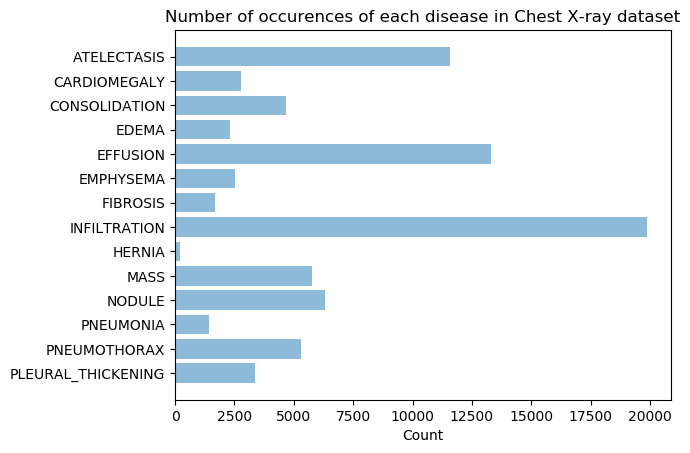

In [0]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt


y_pos = np.arange(len(diseasesNbrN))
 

plt.barh(y_pos, diseasesNbrN, align='center', alpha=0.5)
plt.yticks(y_pos, diseasesLst)
plt.xlabel('Count')
plt.title('Number of occurences of each disease in Chest X-ray dataset')

plt.show()

In [0]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(len(data)))
    ax.set_yticks(np.arange(len(data)))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=["black", "white"],
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A list or array of two color specifications.  The first is used for
        values below a threshold, the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts
  


In [0]:

diseasesNbrM = []

for disease1 in diseasesLst :
  
  diseasesNbrN = []
  
  for disease2 in diseasesLst :
    
    if disease1 == disease2 :
      nbrCur = 0
    else :
      
      filterStr =     " upper(label) like '%" + disease1 +"%' " + "AND  upper(label) like '%" + disease2 +"%' "
      #print(filterStr)
      #nbrCur = 'Number of '+ disease1 +'-' + disease2 +' cases : ' + str(df_response.filter(filterStr).count())
      nbrCur =  df_response.filter(filterStr).count()
    diseasesNbrN.append(nbrCur)
  #print(diseasesNbrN)  
  diseasesNbrM.append(diseasesNbrN)
  #print(diseasesNbrM)
#print(diseasesNbrM)

In [0]:
"""
diseasesNbrM = [[0, 370, 1223, 221, 3275, 424, 220, 3264, 40, 739, 590, 262, 774, 496], [370, 0, 169, 127, 1063, 44, 52, 587, 7, 102, 108, 41, 49, 111], [1223, 169, 0, 162, 1287, 103, 79, 1221, 4, 610, 428, 123, 223, 251], [221, 127, 162, 0, 593, 30, 9, 981, 3, 129, 131, 340, 33, 64], [3275, 1063, 1287, 593, 0, 359, 188, 4000, 21, 1254, 912, 269, 996, 849], [424, 44, 103, 30, 359, 0, 36, 449, 4, 215, 115, 23, 747, 151], [220, 52, 79, 9, 188, 36, 0, 345, 8, 117, 166, 11, 80, 176], [3264, 587, 1221, 981, 4000, 449, 345, 0, 33, 1159, 1546, 605, 946, 750], [40, 7, 4, 3, 21, 4, 8, 33, 0, 25, 10, 3, 9, 8], [739, 102, 610, 129, 1254, 215, 117, 1159, 25, 0, 906, 71, 431, 452], [590, 108, 428, 131, 912, 115, 166, 1546, 10, 906, 0, 70, 341, 411], [262, 41, 123, 340, 269, 23, 11, 605, 3, 71, 70, 0, 41, 48], [774, 49, 223, 33, 996, 747, 80, 946, 9, 431, 341, 41, 0, 289], [496, 111, 251, 64, 849, 151, 176, 750, 8, 452, 411, 48, 289, 0]]
"""
print(diseasesNbrM)

[[0, 370, 1223, 221, 3275, 424, 220, 3264, 40, 739, 590, 262, 774, 496], [370, 0, 169, 127, 1063, 44, 52, 587, 7, 102, 108, 41, 49, 111], [1223, 169, 0, 162, 1287, 103, 79, 1221, 4, 610, 428, 123, 223, 251], [221, 127, 162, 0, 593, 30, 9, 981, 3, 129, 131, 340, 33, 64], [3275, 1063, 1287, 593, 0, 359, 188, 4000, 21, 1254, 912, 269, 996, 849], [424, 44, 103, 30, 359, 0, 36, 449, 4, 215, 115, 23, 747, 151], [220, 52, 79, 9, 188, 36, 0, 345, 8, 117, 166, 11, 80, 176], [3264, 587, 1221, 981, 4000, 449, 345, 0, 33, 1159, 1546, 605, 946, 750], [40, 7, 4, 3, 21, 4, 8, 33, 0, 25, 10, 3, 9, 8], [739, 102, 610, 129, 1254, 215, 117, 1159, 25, 0, 906, 71, 431, 452], [590, 108, 428, 131, 912, 115, 166, 1546, 10, 906, 0, 70, 341, 411], [262, 41, 123, 340, 269, 23, 11, 605, 3, 71, 70, 0, 41, 48], [774, 49, 223, 33, 996, 747, 80, 946, 9, 431, 341, 41, 0, 289], [496, 111, 251, 64, 849, 151, 176, 750, 8, 452, 411, 48, 289, 0]]

In [0]:
fig, ax = plt.subplots()
 


im, cbar = heatmap(diseasesNbrM, diseasesLst, diseasesLst, ax=ax,
                   cmap="YlGn", cbarlabel=" Number of cooccurrences of diseases")
texts = annotate_heatmap(im, valfmt="{x:.1f} t")

fig.tight_layout()
plt.show()